In [16]:
!pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.7/366.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00


In [21]:
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.6 MB/s eta 0:00:00


In [24]:
from qiskit_aer import Aer

backend= Aer.get_backend('statevector_simulator')
#Or "qasm_simulator"

In [25]:
import numpy as np
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
import time

In [26]:
mu = [0.1, 0.2, 0.15, 0.18]
sigma = [[0.04, 0.01, 0.02, 0.03],
         [0.01, 0.09, 0.03, 0.01],
         [0.02, 0.03, 0.16, 0.04],
         [0.03, 0.01, 0.04, 0.25]]

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=0.5, budget=2)
qp = portfolio.to_quadratic_program()


In [30]:
start_classical = time.time()
numpy_solver = NumPyMinimumEigensolver()
classical_result = MinimumEigenOptimizer(numpy_solver).solve(qp)
classical_time = time.time() - start_classical

print("Classical Optimal Portfolio:", classical_result.x)
print("Classical Objective Value:", classical_result.fval)
print("Time taken (Classical):", classical_time, "seconds")


Classical Optimal Portfolio: [1. 1. 0. 0.]
Classical Objective Value: -0.22500000000000003
Time taken (Classical): 0.022162199020385742 seconds


start_qaoa = time.time()
qaoa = QAOA(optimizer=COBYLA(), reps=1, sampler)
qaoa_result = MinimumEigenOptimizer(qaoa).solve(qp)
qaoa_time = time.time() - start_qaoa

print("QAOA Optimal Portfolio:", qaoa_result.x)
print("QAOA Objective Value:", qaoa_result.fval)
print("Time taken (QAOA):", qaoa_time, "seconds")


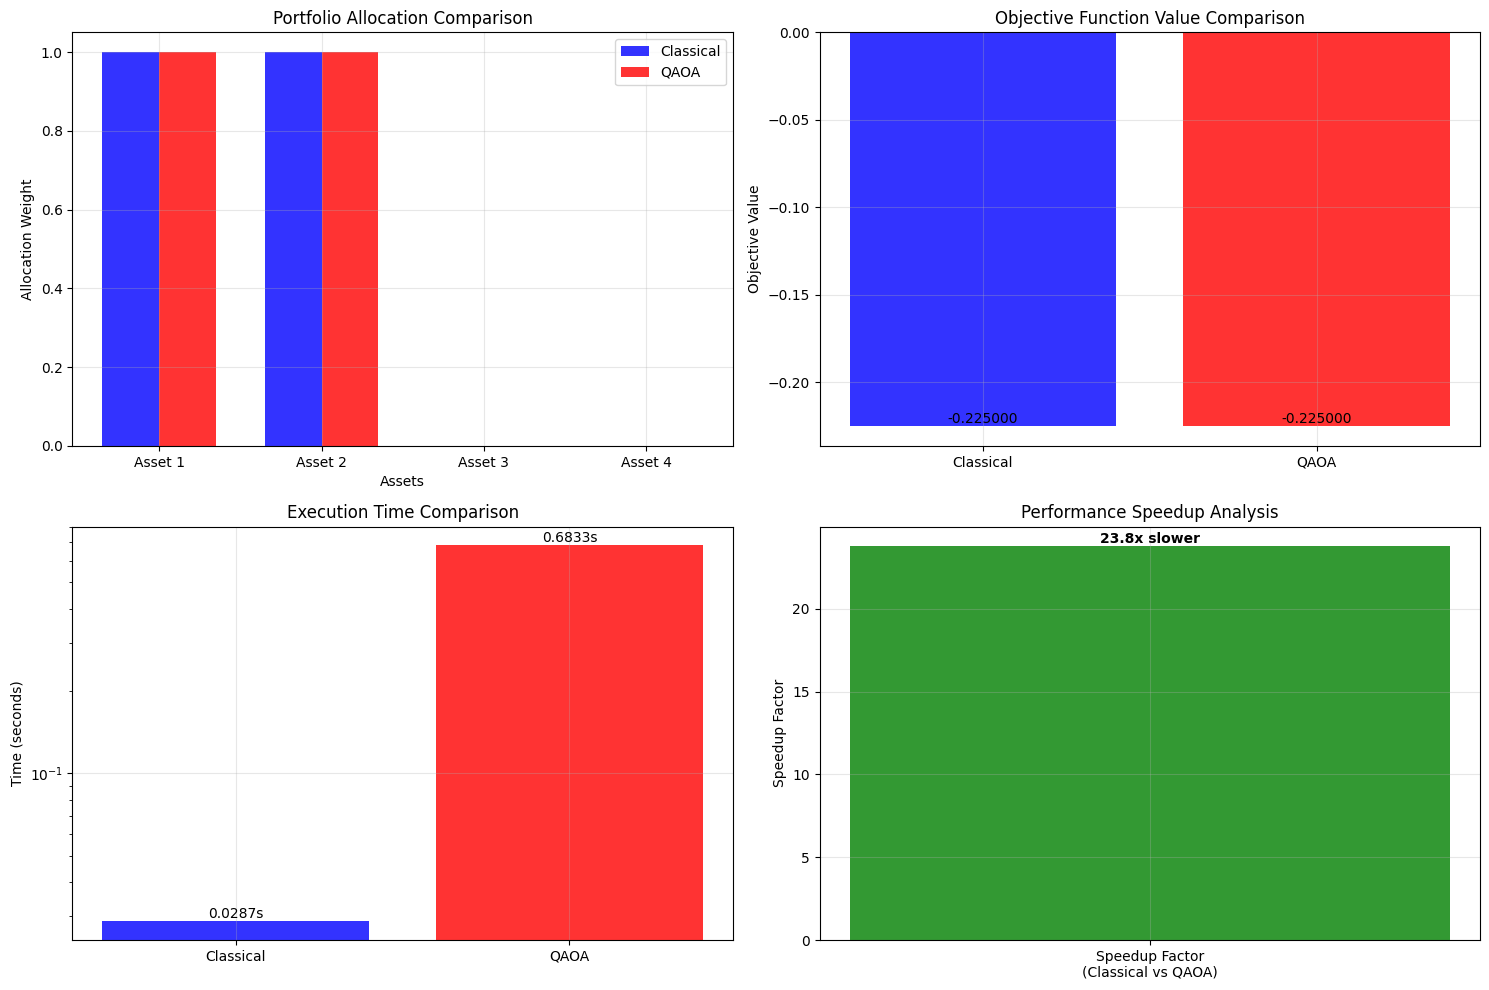

PORTFOLIO OPTIMIZATION RESULTS SUMMARY
Classical Optimization:
  • Portfolio: [1. 1. 0. 0.]
  • Objective Value: -0.225000
  • Execution Time: 0.028733 seconds

QAOA Optimization:
  • Portfolio: [1. 1. 0. 0.]
  • Objective Value: -0.225000
  • Execution Time: 0.683261 seconds

Performance Analysis:
  • Objective Difference: 0.0000000000
  • Time Ratio (QAOA/Classical): 23.8x
  • Solution Quality: Identical


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results from your code
classical_portfolio = np.array([1., 1., 0., 0.])
qaoa_portfolio = np.array([1., 1., 0., 0.])
classical_objective = -0.225
qaoa_objective = -0.225
classical_time = 0.028733253479003906
qaoa_time = 0.6832611560821533

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Portfolio Allocation Comparison
assets = ['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4']
x_pos = np.arange(len(assets))
width = 0.35

ax1.bar(x_pos - width/2, classical_portfolio, width, label='Classical', alpha=0.8, color='blue')
ax1.bar(x_pos + width/2, qaoa_portfolio, width, label='QAOA', alpha=0.8, color='red')
ax1.set_xlabel('Assets')
ax1.set_ylabel('Allocation Weight')
ax1.set_title('Portfolio Allocation Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(assets)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Objective Function Value Comparison
methods = ['Classical', 'QAOA']
objectives = [classical_objective, qaoa_objective]
colors = ['blue', 'red']

bars = ax2.bar(methods, objectives, color=colors, alpha=0.8)
ax2.set_ylabel('Objective Value')
ax2.set_title('Objective Function Value Comparison')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, objectives):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.6f}', ha='center', va='bottom')

# 3. Execution Time Comparison
times = [classical_time, qaoa_time]
bars = ax3.bar(methods, times, color=colors, alpha=0.8)
ax3.set_ylabel('Time (seconds)')
ax3.set_title('Execution Time Comparison')
ax3.set_yscale('log')  # Log scale due to large difference
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, time in zip(bars, times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{time:.4f}s', ha='center', va='bottom')

# 4. Speedup Analysis
speedup_factor = qaoa_time / classical_time
ax4.bar(['Speedup Factor\n(Classical vs QAOA)'], [speedup_factor],
        color='green', alpha=0.8)
ax4.set_ylabel('Speedup Factor')
ax4.set_title('Performance Speedup Analysis')
ax4.text(0, speedup_factor, f'{speedup_factor:.1f}x slower',
         ha='center', va='bottom', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*60)
print("PORTFOLIO OPTIMIZATION RESULTS SUMMARY")
print("="*60)
print(f"Classical Optimization:")
print(f"  • Portfolio: {classical_portfolio}")
print(f"  • Objective Value: {classical_objective:.6f}")
print(f"  • Execution Time: {classical_time:.6f} seconds")
print(f"\nQAOA Optimization:")
print(f"  • Portfolio: {qaoa_portfolio}")
print(f"  • Objective Value: {qaoa_objective:.6f}")
print(f"  • Execution Time: {qaoa_time:.6f} seconds")
print(f"\nPerformance Analysis:")
print(f"  • Objective Difference: {abs(classical_objective - qaoa_objective):.10f}")
print(f"  • Time Ratio (QAOA/Classical): {qaoa_time/classical_time:.1f}x")
print(f"  • Solution Quality: {'Identical' if np.allclose(classical_portfolio, qaoa_portfolio) else 'Different'}")